In [1]:
from pathlib import Path
from typing import Dict, List

from hear21passt.base import load_model
import pandas as pd
from sklearn.metrics import f1_score
import torch
import torchaudio
from tqdm import tqdm


DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 527
TARGET_SR = 32_000

In [2]:
class AudioSetDataset(torch.utils.data.Dataset):
    def __init__(self, root: Path, labels: Dict[str, List[int]], audio_len: float = 10.0):
        self._root = root
        self._names = sorted(labels.keys())
        self._labels = labels
        self._num_samples = int(audio_len * TARGET_SR)
    
    def __getitem__(self, index):
        name = self._names[index]

        path = self._root / (name + '.wav')
        wav, sr = torchaudio.load(str(path))
        assert wav.dim() == 2
        wav = torch.mean(wav, dim=0)
        if len(wav) > 0:
            wav = torchaudio.functional.resample(wav, sr, TARGET_SR)
        if len(wav) > self._num_samples:
            wav = wav[:self._num_samples]

        labels = self._labels[name]
        target = torch.zeros(NUM_CLASSES)
        for label in labels:
            target[label] = 1.0

        return wav, target

    def __len__(self):
        return len(self._names)

In [3]:
csv = pd.read_csv('data/audioset/class_labels_indices.csv')
label2ind = {}
for index, row in csv.iterrows():
    label2ind[row.mid] = index

In [4]:
csv = pd.read_csv('data/audioset/val/valid.csv')
name2labels = {}
for _, row in csv.iterrows():
    name2labels[row.YTID] = [label2ind[label] for label in row.positive_labels.split(',')]

In [5]:
ds = AudioSetDataset(Path('data/audioset/val/valid_wav'), name2labels)
loader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
model = load_model(mode='logits').eval().to(DEVICE)



 Loading PASST TRAINED ON AUDISET 


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwi

In [6]:
def evaluate_thresholds(model, loader, thresholds):
    scores = torch.zeros(len(thresholds))
    model.eval()
    for x, y in tqdm(loader):
        if x.numel() == 0:
            continue
        x = x.to(DEVICE)
        with torch.no_grad():
            probs = torch.sigmoid(model(x)).cpu()
        for i, threshold in enumerate(thresholds):
            predictions = (probs > threshold).int()
            scores[i] += f1_score(predictions.squeeze(), y.squeeze())
    return scores / len(loader)

In [9]:
import warnings
warnings.filterwarnings("ignore")


thresholds = torch.linspace(0.1, 0.9, 9)
scores = evaluate_thresholds(model, loader, thresholds)
print(scores)

100%|██████████| 17979/17979 [57:03<00:00,  5.25it/s] 

tensor([0.4737, 0.5023, 0.4869, 0.4491, 0.3952, 0.3262, 0.2428, 0.1462, 0.0484])


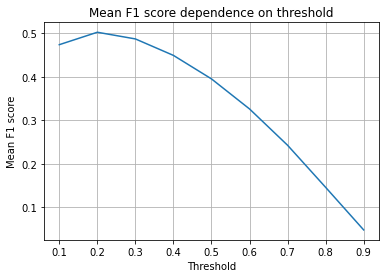

In [14]:
import matplotlib.pyplot as plt

_ = plt.title('Mean F1 score dependence on threshold')
_ = plt.xlabel('Threshold')
_ = plt.ylabel('Mean F1 score')
_ = plt.grid()
_ = plt.plot(thresholds, scores)
_ = plt.savefig('thresholds.jpg')

In [9]:
import warnings
warnings.filterwarnings("ignore")


thresholds = torch.linspace(0.1, 0.3, 21)
scores = evaluate_thresholds(model, loader, thresholds)
print(scores)

100%|██████████| 17979/17979 [1:02:04<00:00,  4.83it/s]

tensor([0.4737, 0.4805, 0.4864, 0.4911, 0.4944, 0.4978, 0.4997, 0.5012, 0.5015,
        0.5020, 0.5023, 0.5018, 0.5010, 0.5003, 0.4989, 0.4974, 0.4958, 0.4944,
        0.4921, 0.4892, 0.4869])


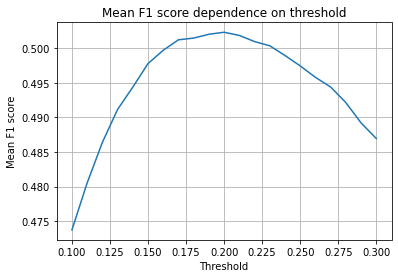

In [11]:
import matplotlib.pyplot as plt

_ = plt.title('Mean F1 score dependence on threshold')
_ = plt.xlabel('Threshold')
_ = plt.ylabel('Mean F1 score')
_ = plt.grid()
_ = plt.plot(thresholds, scores)
_ = plt.savefig('thresholds_small.jpg')